In [124]:
# drop rows containing 6 and 7 zeros in demographic data

## Imports and Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# imputation
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

In [2]:
def clean_col(col_name):
    '''
    Rename columns to be more Pythonic:
    - lowercase
    - underscore between words
    - replace some language with more descriptive examples
    
    Return revised column name.
    '''
    col_name = col_name.lower()
    col_name = col_name.replace('pct','_pct')
    col_name = col_name.replace('state','st')
    col_name = col_name.replace('acstot','')
    col_name = col_name.replace('minor','poc')
    col_name = col_name.replace('less','sub_')
    col_name = col_name.replace('lowinc','low_inc')
    col_name = col_name.replace('ling','ling_')
    col_name = col_name.replace('under5','under_5')
    col_name = col_name.replace('over64','over_64')
    col_name = col_name.replace('vuleo_pct','dem_index')
    col_name = col_name.replace('pre1960','pre_1960')
    col_name = col_name.replace('ptraf','traffic_prox')
    col_name = col_name.replace('dslpm','diesel_pm')
    col_name = col_name.replace('pnpl','npl_prox')
    col_name = col_name.replace('prmp','rmp_prox')
    col_name = col_name.replace('ptsdf','waste_prox')
    col_name = col_name.replace('resp','resp_index')
    col_name = col_name.replace('pwdis','waste_water')
    col_name = col_name.replace('25','_25')
    col_name = col_name.replace('ust','undgrd_stor')
    
    return col_name
    

---
## Basic Cleaning

In [3]:
raw_data = pd.read_csv('data/EJSCREEN_2021_StatePctile_Tracts.csv')

C:\Users\John\AppData\Local\Temp\ipykernel_10828\3077557032.py:1: DtypeWarning: Columns (128,129,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('data/EJSCREEN_2021_StatePctile_Tracts.csv')


Columns beginning with `B_` and `T_` provide information for creating specialized images. This is not necessary for our exploratory data analysis so we will drop these columns. Columns beginning with `P_` and `D_` contain percentile and index data. These can be reconstructed from other columns without much difficulty, so we will drop these as well.

There is also identification and shape data that we do not need for eda. These columns are located in the first two and last two columns. We will drop these columns, too.

In [4]:
# initial columns of interest
# cut columns related to image data, clean the rest
init_cols = [col for col in raw_data.columns if col[:2] not in 'P_B_T_D_']

# drop OBJECTID - repeated index col
# drop Shape cols
init_cols = init_cols[2:-2]
init_cols

['STATE_NAME',
 'ST_ABBREV',
 'REGION',
 'ACSTOTPOP',
 'MINORPCT',
 'LOWINCPCT',
 'LESSHSPCT',
 'LINGISOPCT',
 'UNDER5PCT',
 'OVER64PCT',
 'UNEMPPCT',
 'VULEOPCT',
 'PRE1960PCT',
 'DSLPM',
 'CANCER',
 'RESP',
 'PTRAF',
 'PWDIS',
 'PNPL',
 'PRMP',
 'PTSDF',
 'OZONE',
 'PM25',
 'UST']

Below we change the column labels to lower case and include an underscore to between the `PCT` (representing percent) to make the columns a bit more readable.

In [5]:
env = raw_data[init_cols].copy()
env.columns = [clean_col(col) for col in env.columns]

To check the results, we list out the revised column names.

In [6]:
env.columns

Index(['st_name', 'st_abbrev', 'region', 'pop', 'poc_pct', 'low_inc_pct',
       'sub_hs_pct', 'ling_iso_pct', 'under_5_pct', 'over_64_pct', 'unemp_pct',
       'dem_index', 'pre_1960_pct', 'diesel_pm', 'cancer', 'resp_index',
       'traffic_prox', 'waste_water', 'npl_prox', 'rmp_prox', 'waste_prox',
       'ozone', 'pm_25', 'undgrd_stor'],
      dtype='object')

There are few hundred rows of data where the numeric entries consist entirely of zeros or missing values. These rows will be impossible to work with and should be removed.

In [7]:
# drop rows containing no information (consisting of ALL zeros and nulls)

# identify location of first and last numeric columns
pop_index = env.columns.get_loc('pop')
stor_index = env.columns.get_loc('undgrd_stor')

# count nulls within a row
nulls_in_row = env.iloc[:,pop_index:stor_index+1].isnull().sum(axis = 1)
# count zeros within a row
zeros_in_row = (env.iloc[:,pop_index:stor_index+1] == 0).sum(axis = 1)

# if zeros and nulls sum to number of numeric columns, drop the row
total_num_cols = env.iloc[:,pop_index:stor_index+1].shape[1]
env.drop(index = env[nulls_in_row + zeros_in_row == total_num_cols].index, inplace = True)

One of our major goals is to predict the air toxics cancer risk given by the `cancer` column. Since this column is especially valuable to us, we want to avoid imputing missing values within it. Below we see it contains 246 missing values.

In [8]:
env.isnull().sum()

st_name             0
st_abbrev           0
region              0
pop                 0
poc_pct             0
low_inc_pct         0
sub_hs_pct          0
ling_iso_pct        0
under_5_pct         0
over_64_pct         0
unemp_pct           0
dem_index           0
pre_1960_pct        0
diesel_pm         246
cancer            246
resp_index        246
traffic_prox     2343
waste_water     19644
npl_prox            0
rmp_prox            0
waste_prox          0
ozone            1383
pm_25            1383
undgrd_stor         0
dtype: int64

Before we drop the rows missing `cancer` data, we check to see if the entries seem genuinely random and that we are not introducing any blatant bias to our dataset. Since the states of these entries seem reasonably distributed, it feels fair to assume they are random.

In [9]:
env.loc[env['cancer'].isna(), 'st_name'].value_counts()

New York          31
Florida           26
California        18
Texas             16
Michigan          13
Virginia          12
Louisiana         12
North Carolina    10
Tennessee          8
Colorado           7
Pennsylvania       7
Georgia            7
Nevada             7
South Carolina     6
Illinois           6
Arizona            6
Massachusetts      5
Kentucky           5
Mississippi        4
Maryland           4
Kansas             4
New Hampshire      3
Utah               3
Ohio               3
Oregon             3
Washington         3
Wisconsin          3
New Jersey         2
Iowa               2
Missouri           2
Vermont            1
Alabama            1
New Mexico         1
Minnesota          1
Indiana            1
Delaware           1
Connecticut        1
Wyoming            1
Name: st_name, dtype: int64

In [10]:
env.dropna(subset = ['cancer'], inplace = True)

In [11]:
env.drop(columns = ['dem_index', 'waste_water'], inplace = True)

Conveniently, dropping the rows with missing `cancer` values coincided with rows missing `diesel_pm` and `resp_index`.

In [12]:
env.isnull().sum()

st_name            0
st_abbrev          0
region             0
pop                0
poc_pct            0
low_inc_pct        0
sub_hs_pct         0
ling_iso_pct       0
under_5_pct        0
over_64_pct        0
unemp_pct          0
pre_1960_pct       0
diesel_pm          0
cancer             0
resp_index         0
traffic_prox    2103
npl_prox           0
rmp_prox           0
waste_prox         0
ozone           1383
pm_25           1383
undgrd_stor        0
dtype: int64

Another thing to be cautious of is that several columns are based on percentages of the population. These percentages can be somewhat deceptive for rows containing lower populations. For example, 100% of the population being minority feels more meaningful when the population size is 2416 than if the population size is 8. For this reason we want to filter out rows with especially small population sizes.

Additionally, each row represents a Census tract. Census tracts generally have a population size above 1,200. Rows with a population size below 1,200 correspond to tribal data. We do not want to eliminate the tribal data, especially with the history of environmental injustice towards indigenous people. For this reason, we will set a population size of 30 as a lower bound for the data. This way, we can feel more confident in interpreting percentages and still keep as much of the tribal data as possible.

Below we verify that the data corresponding to population sizes below 30 is reasonably distributed across all states.

In [13]:
env.loc[env['pop'] <= 30, 'st_name'].value_counts()

New York          34
Florida           19
California        18
Texas             15
Pennsylvania      15
Puerto Rico       10
Virginia          10
Tennessee          9
Hawaii             8
Kansas             6
Michigan           6
North Carolina     5
Massachusetts      4
Missouri           4
Louisiana          4
Arizona            4
Ohio               3
Alabama            3
Kentucky           3
Maryland           2
New Jersey         2
Indiana            2
Georgia            2
Rhode Island       1
Washington         1
Arkansas           1
South Carolina     1
Montana            1
Idaho              1
Nebraska           1
Oklahoma           1
Alaska             1
Illinois           1
Nevada             1
Oregon             1
Name: st_name, dtype: int64

In [14]:
env = env[env['pop']>=30]

In [15]:
env

,st_name,st_abbrev,region,pop,poc_pct,low_inc_pct,sub_hs_pct,ling_iso_pct,under_5_pct,over_64_pct,...,diesel_pm,cancer,resp_index,traffic_prox,npl_prox,rmp_prox,waste_prox,ozone,pm_25,undgrd_stor
0,Alabama,AL,4,1993,0.167587,0.274962,0.125472,0.000000,0.057702,0.132464,...,0.175377,40.0,0.5,35.919960,0.066752,0.077960,0.500305,37.010497,9.152519,0.412039
1,Alabama,AL,4,1959,0.617152,0.435927,0.148254,0.000000,0.050536,0.144972,...,0.193126,40.0,0.5,159.744710,0.072665,0.082735,0.818620,37.038957,9.183280,2.461319
2,Alabama,AL,4,3507,0.348446,0.293128,0.149701,0.000000,0.027659,0.160251,...,0.224637,40.0,0.5,169.977159,0.075655,0.082532,1.299859,37.069151,9.207049,1.987063
3,Alabama,AL,4,3878,0.103146,0.216864,0.081583,0.023881,0.041774,0.244714,...,0.270230,40.0,0.5,500.544361,0.084317,0.087633,2.056273,37.087437,9.231752,3.362111
4,Alabama,AL,4,10596,0.290959,0.203222,0.079653,0.019630,0.047659,0.138071,...,0.301774,40.0,0.5,220.210382,0.093815,0.090465,1.082545,37.123515,9.242796,2.222632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73996,Puerto Rico,PR,2,6113,0.998528,0.821821,0.141336,0.782748,0.034189,0.132504,...,0.019051,20.0,0.2,124.806305,0.056280,0.726861,1.591806,NaN,NaN,0.000000
73997,Puerto Rico,PR,2,2388,0.992044,0.656198,0.169355,0.635171,0.069095,0.147404,...,0.020953,20.0,0.2,980.891997,0.058924,0.850649,1.486320,NaN,NaN,0.000000
73998,Puerto Rico,PR,2,2126,0.998119,0.808090,0.182512,0.680067,0.039511,0.210254,...,0.017332,20.0,0.2,247.918471,0.056189,0.585214,0.961161,NaN,NaN,0.000000
73999,Puerto Rico,PR,2,4397,1.000000,0.763475,0.133858,0.583131,0.082101,0.173073,...,0.018709,20.0,0.2,94.823564,0.065705,1.565644,0.762340,NaN,NaN,0.123067


-------------------------------------

### EDA Visulization

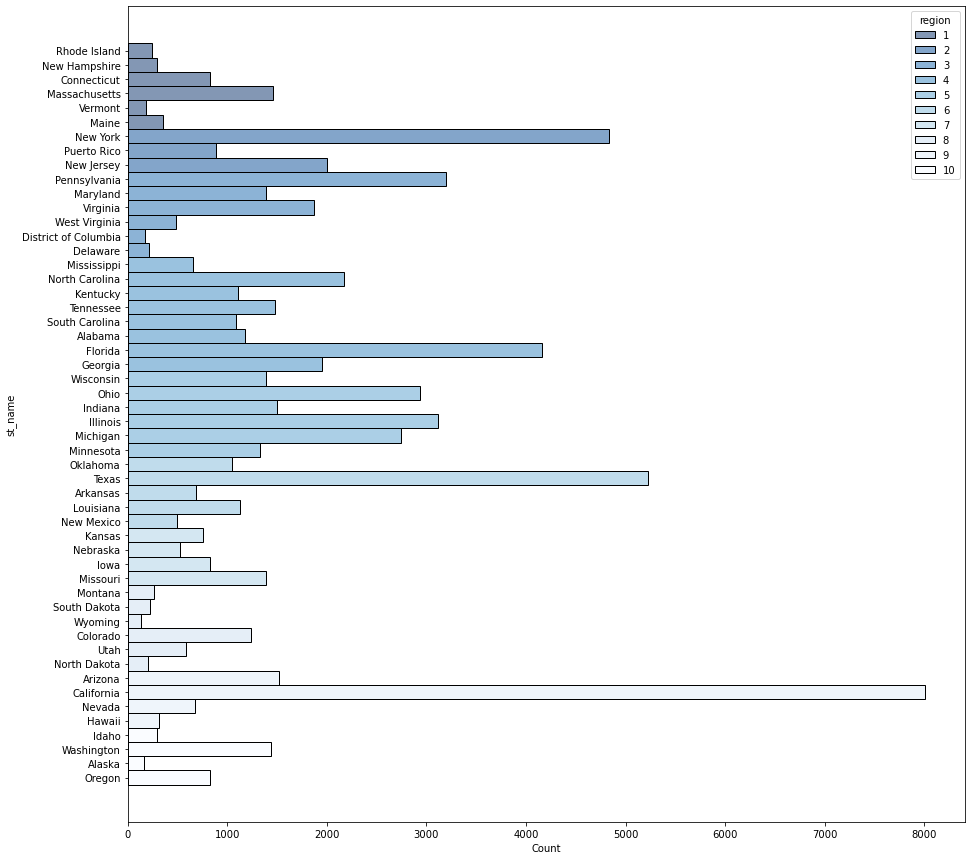

In [16]:
plt.figure(figsize = (15,15))
sns.histplot(data = env.sort_values(by = 'region'), y = 'st_name', hue = 'region', palette = 'Blues_r');
#env.groupby('region')['st_name'].value_counts().sort_values(ascending = False).plot(kind = 'barh')
#env['st_name'].value_counts().plot(kind = 'barh')


Region vs Environmnetal Factors

In [17]:
env.drop([73723], inplace = True)

C:\Users\John\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


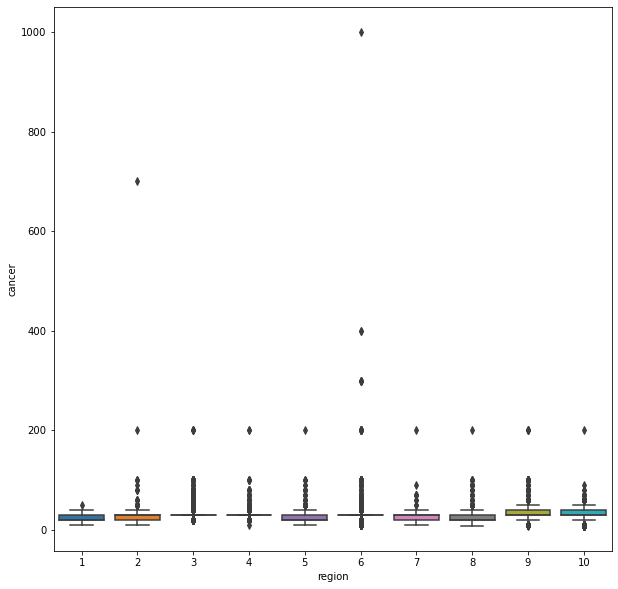

In [18]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['cancer']);

C:\Users\John\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


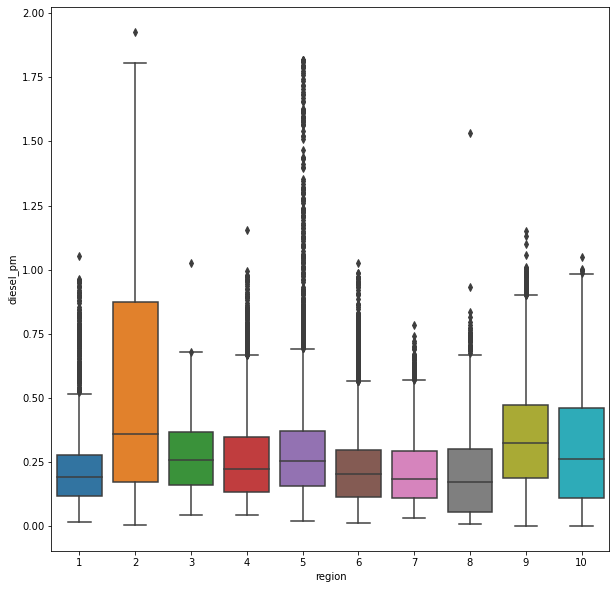

In [19]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['diesel_pm']);

C:\Users\John\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


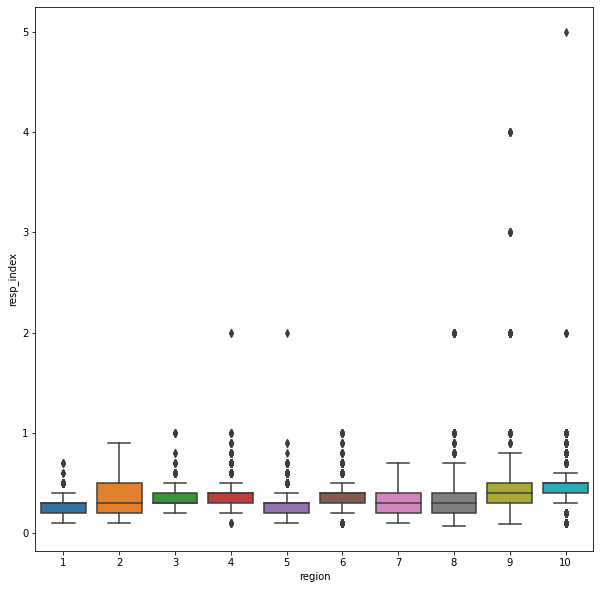

In [20]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['resp_index']);

C:\Users\John\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


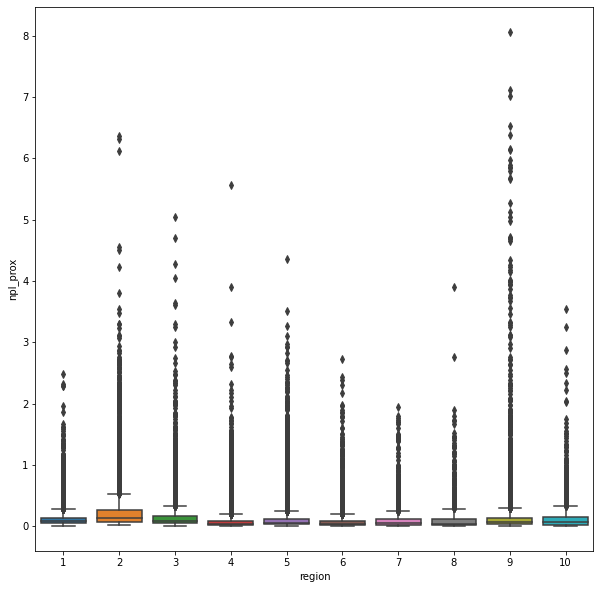

In [21]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['npl_prox']);

C:\Users\John\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


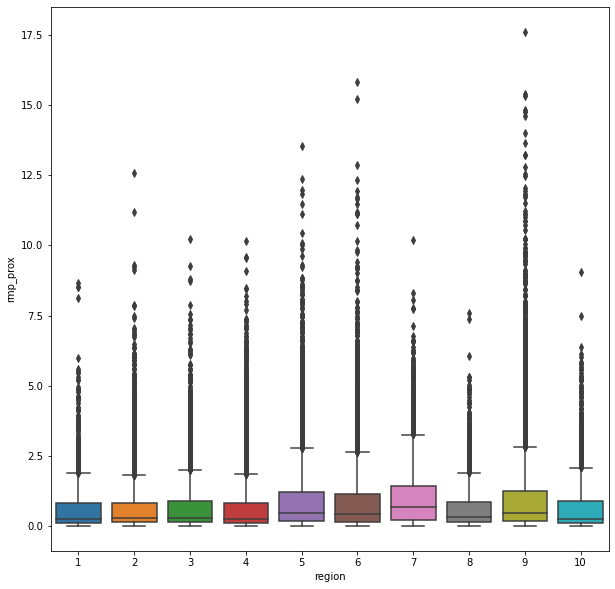

In [22]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['rmp_prox']);

C:\Users\John\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


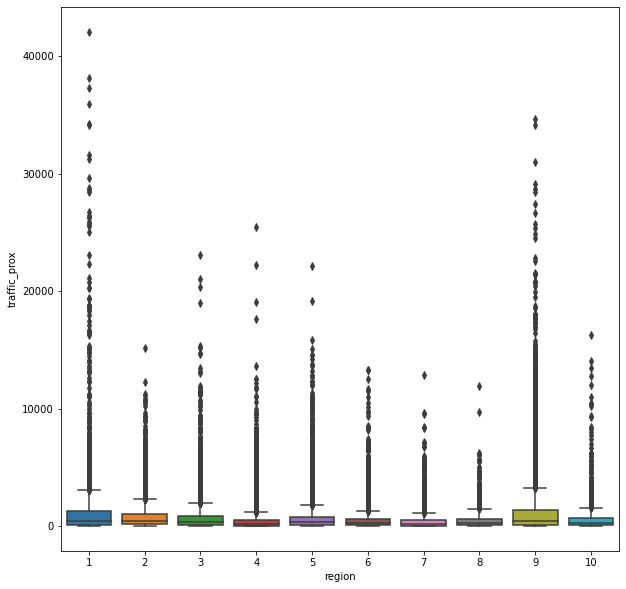

In [23]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['traffic_prox']);

C:\Users\John\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


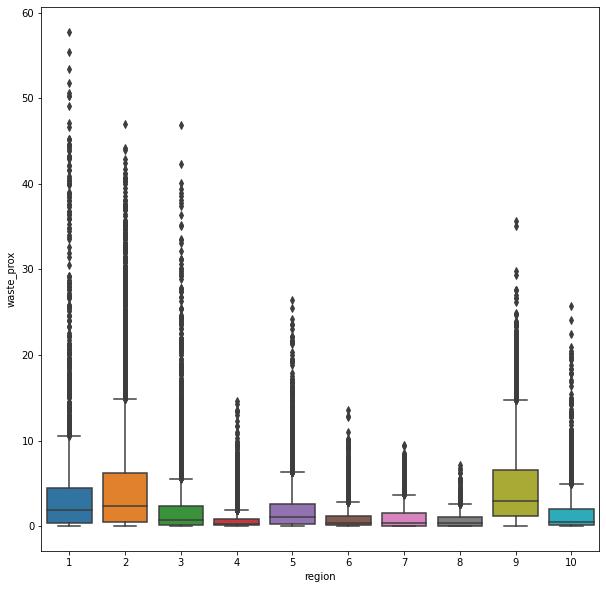

In [24]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['waste_prox']);

C:\Users\John\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


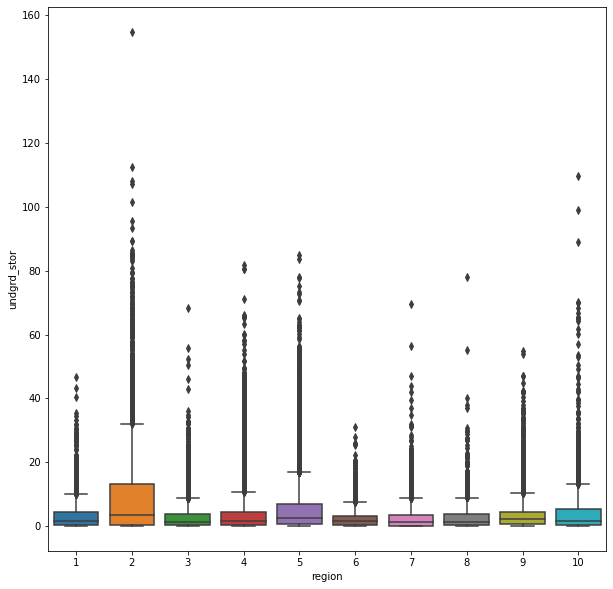

In [25]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['undgrd_stor']);

Region vs Demographic factor boxplots

C:\Users\John\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


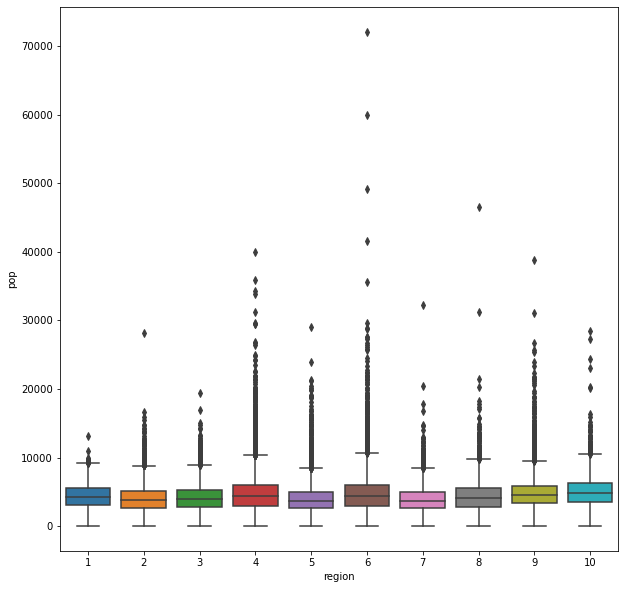

In [26]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['pop']);

In [27]:
env.groupby('region')['poc_pct'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3357.0,0.252845,0.247699,0.00000,0.071048,0.149312,0.350768,1.000000
2,7720.0,0.509903,0.353195,0.00000,0.175422,0.443389,0.904438,1.000000
3,7336.0,0.327717,0.290602,0.00000,0.085472,0.230732,0.504293,1.000000
4,13796.0,0.383142,0.281531,0.00000,0.144674,0.315469,0.576817,1.000000
5,13035.0,0.283263,0.285461,0.00000,0.069548,0.164111,0.398925,1.000000
6,8575.0,0.512756,0.279952,0.00000,0.274027,0.475126,0.760019,1.000000
7,3501.0,0.210558,0.221507,0.00000,0.061475,0.128232,0.264438,1.000000
8,2655.0,0.243526,0.196344,0.00000,0.103636,0.180891,0.323793,0.991048
9,10512.0,0.585996,0.264917,0.00000,0.357073,0.589939,0.832241,1.000000


C:\Users\John\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


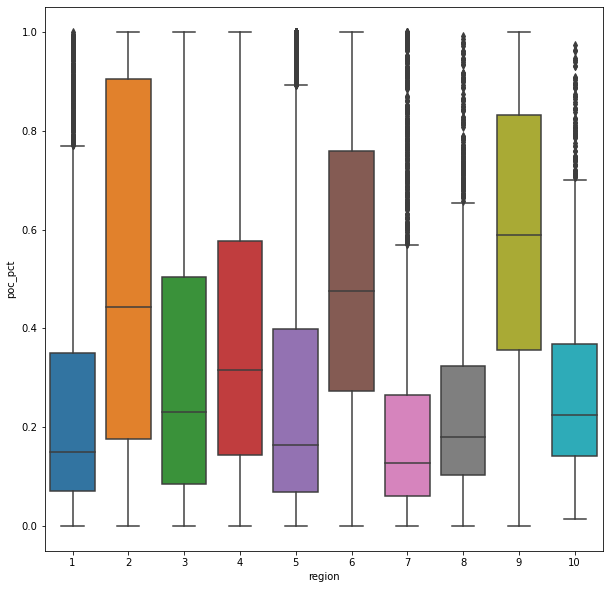

In [28]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['poc_pct']);

Environmental factors boxplot

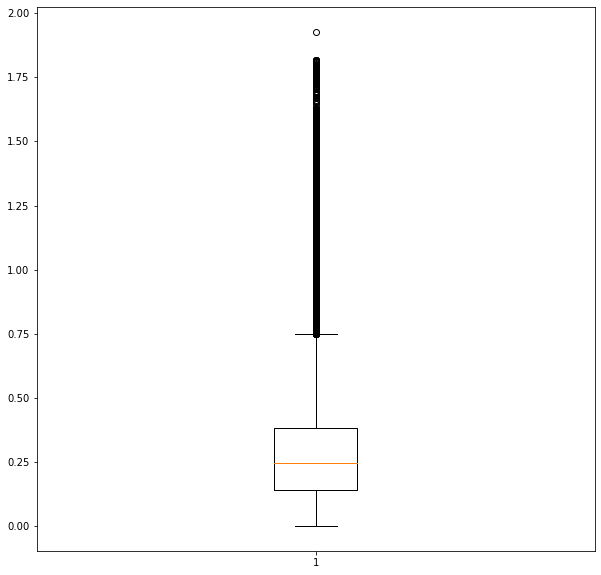

In [29]:
plt.figure(figsize = (10,10))
plt.boxplot(env['diesel_pm']);

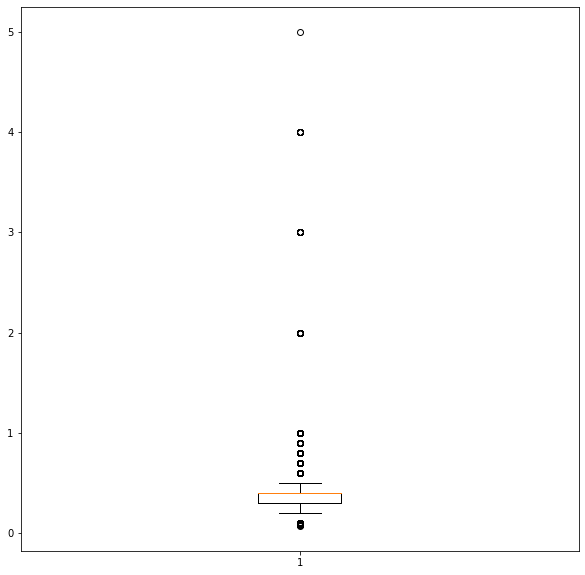

In [30]:
plt.figure(figsize = (10,10))
plt.boxplot(env['resp_index']);

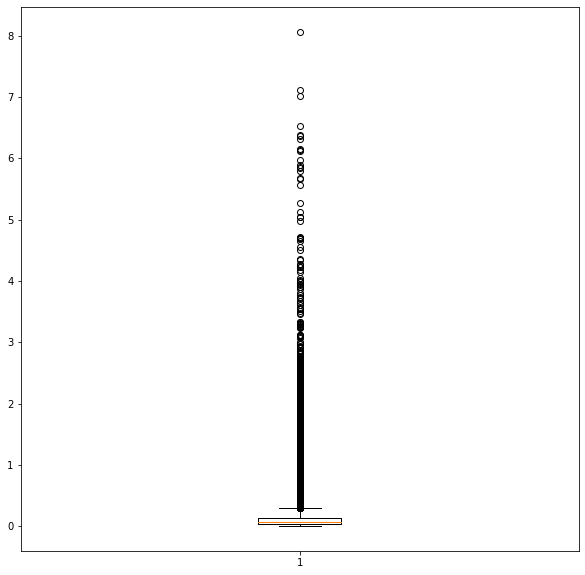

In [31]:
plt.figure(figsize = (10,10))
plt.boxplot(env['npl_prox']);

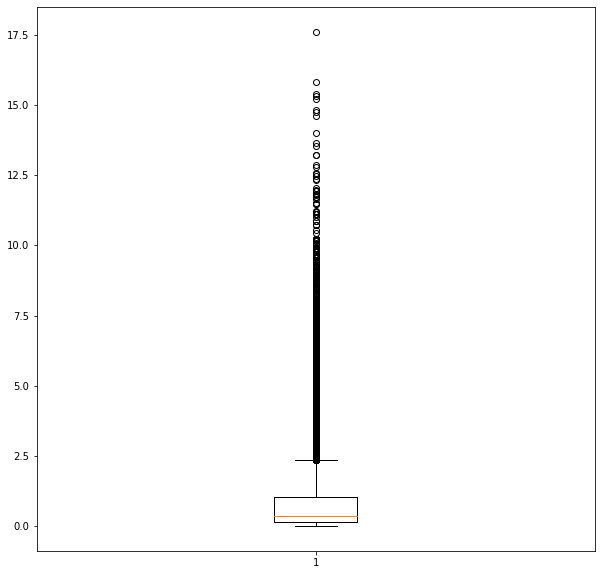

In [32]:
plt.figure(figsize = (10,10))
plt.boxplot(env['rmp_prox']);

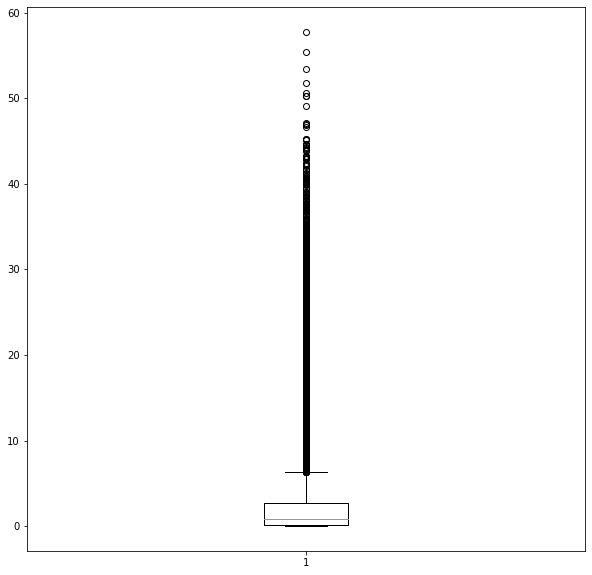

In [33]:
plt.figure(figsize = (10,10))
plt.boxplot( env['waste_prox']);

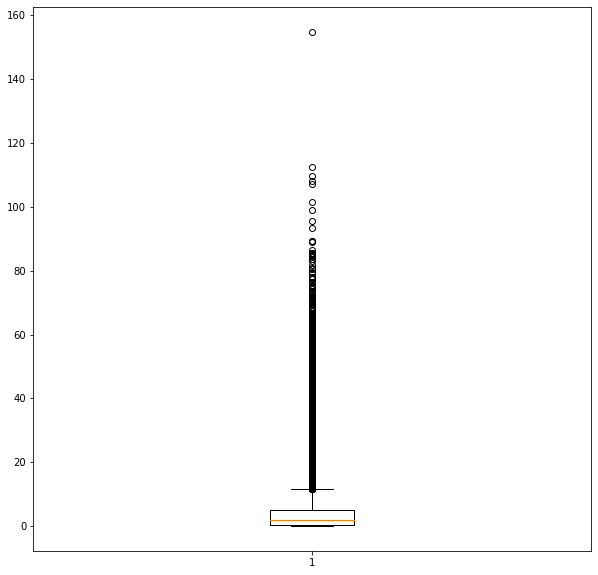

In [34]:
plt.figure(figsize = (10,10))
plt.boxplot(env['undgrd_stor']);

---

## Imputing

In [35]:
cols_to_impute = ['traffic_prox', 'ozone', 'pm_25']

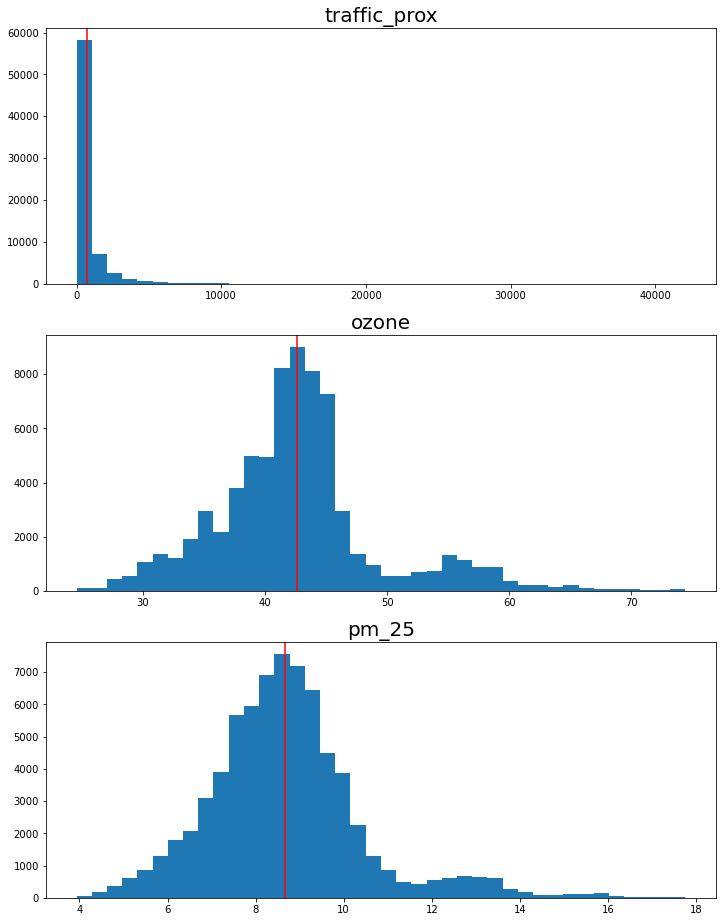

In [36]:
plt.figure(figsize = (12,16))

for i in range(3):
    plt.subplot(3,1,i+1)
    col_name = cols_to_impute[i]
    plt.title(f'{col_name}', size = 20)
    plt.hist(env[col_name], bins = 40)
    plt.axvline(env[col_name].mean(), color = 'red')
    

In [37]:
# may want to one-hot-encode region to impute using regression 
X = env.drop(columns = ['cancer', 'st_name', 'st_abbrev'])
y = env['cancer']

In [38]:
X_train, X_val, Y_train, Y_val = train_test_split(X,y, test_size = 0.2, random_state = 13)

In [39]:
it = IterativeImputer(estimator = LinearRegression())
X_train_missing = it.fit_transform(X_train)
X_val_missing = it.transform(X_val)

X_train_imputed = pd.DataFrame(X_train_missing, columns = it.get_feature_names_out())
X_val_imputed = pd.DataFrame(X_val_missing, columns = it.get_feature_names_out())

In [40]:
X_imputed = pd.concat([X_train_imputed, X_val_imputed])

In [41]:
X_imputed

,region,pop,poc_pct,low_inc_pct,sub_hs_pct,ling_iso_pct,under_5_pct,over_64_pct,unemp_pct,pre_1960_pct,diesel_pm,resp_index,traffic_prox,npl_prox,rmp_prox,waste_prox,ozone,pm_25,undgrd_stor
0,2.0,4045.0,0.401236,0.259727,0.143237,0.044361,0.038072,0.164400,0.060688,0.361671,0.305874,0.3,244.094471,0.125307,0.086791,1.313213,43.804595,7.439898,1.680509
1,2.0,5118.0,0.161782,0.127372,0.033595,0.037461,0.052755,0.203204,0.036295,0.547035,0.277527,0.3,402.408271,0.092864,0.228712,0.414198,42.045325,7.491417,10.711699
2,3.0,2550.0,0.506667,0.643683,0.226740,0.021075,0.151765,0.049020,0.099571,0.302785,0.254800,0.3,885.145986,0.172876,1.160913,0.825702,44.921961,7.734490,1.203185
3,6.0,2637.0,0.098976,0.511407,0.250522,0.035680,0.086841,0.139173,0.033569,0.098077,0.060401,0.5,0.026620,0.408759,0.128420,0.028133,38.430395,8.820738,0.024831
4,7.0,4208.0,0.284696,0.321530,0.049782,0.028432,0.060837,0.123099,0.070169,0.874308,0.579414,0.5,1055.238398,0.116735,0.517442,3.335104,48.547152,9.451945,3.032293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14639,6.0,4072.0,0.421169,0.430723,0.224621,0.029172,0.095776,0.154715,0.081924,0.439952,0.113892,0.4,48.350477,0.029632,0.871878,0.040546,39.027198,9.488393,1.539221
14640,1.0,5151.0,0.055911,0.143394,0.073560,0.010501,0.039410,0.221510,0.060544,0.248111,0.123280,0.2,117.476119,0.042640,0.045132,0.892260,41.704182,6.029829,0.850917
14641,5.0,2834.0,0.938250,0.418630,0.063304,0.004596,0.087509,0.086097,0.105263,0.821567,0.324143,0.3,1445.048769,0.144207,0.577823,1.428223,45.089852,9.920975,30.780750
14642,5.0,6648.0,0.340704,0.458847,0.081584,0.006780,0.096871,0.101384,0.054037,0.231471,0.345399,0.3,394.387992,0.236663,1.607285,0.945679,47.107778,10.104725,1.763924


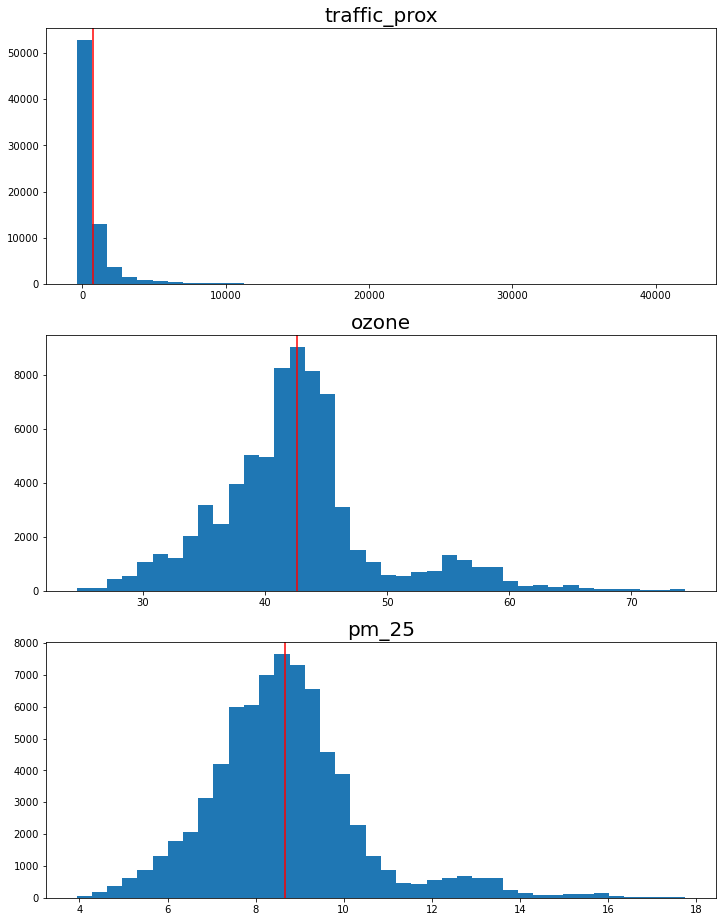

In [42]:
cols_to_impute = ['traffic_prox', 'ozone', 'pm_25']

plt.figure(figsize = (12,16))

for i in range(3):
    plt.subplot(3,1,i+1)
    col_name = cols_to_impute[i]
    plt.title(f'{col_name}', size = 20)
    plt.hist(X_imputed[col_name], bins = 40)
    plt.axvline(X_imputed[col_name].mean(), color = 'red')
    

---

## For the Team

Below is code showing that if we drop the null values outside of `waste_water`, we eliminate Puerto Rico, Hawaii, and Alaska from the entire dataset. These three territories seem to only be missing `ozone` and `pm_25` data.

In [44]:
# collect rows where there are any missing values
# besides waste_water with 20,000 missing values

# na_rows are the incdices of null values
# has_na is the dataset containing null
#na_rows = env.select_dtypes(include = 'number').drop(columns = ['waste_water']).isna().any(axis = 1)
#has_na = env[na_rows]

In [46]:
# 10 states with the most null values in the dataset currently
# null_states = has_na['st_abbrev'].value_counts().head(10).index
# has_na['st_abbrev'].value_counts().head(10)

In [47]:
# the total number of appearances of these states in the entire dataset
#env['st_abbrev'].value_counts()[null_states]

Another thing to note about these three groups is that their nulls are primarily located in in the `ozone` and `pm_25` columns.

In [48]:
# for territory in ['PR', 'HI', 'AK']:
#     print(territory)
#     print(env[env['st_abbrev'] == territory].isnull().sum(), '\n\n')

----

In [45]:
env

,st_name,st_abbrev,region,pop,poc_pct,low_inc_pct,sub_hs_pct,ling_iso_pct,under_5_pct,over_64_pct,...,diesel_pm,cancer,resp_index,traffic_prox,npl_prox,rmp_prox,waste_prox,ozone,pm_25,undgrd_stor
0,Alabama,AL,4,1993,0.167587,0.274962,0.125472,0.000000,0.057702,0.132464,...,0.175377,40.0,0.5,35.919960,0.066752,0.077960,0.500305,37.010497,9.152519,0.412039
1,Alabama,AL,4,1959,0.617152,0.435927,0.148254,0.000000,0.050536,0.144972,...,0.193126,40.0,0.5,159.744710,0.072665,0.082735,0.818620,37.038957,9.183280,2.461319
2,Alabama,AL,4,3507,0.348446,0.293128,0.149701,0.000000,0.027659,0.160251,...,0.224637,40.0,0.5,169.977159,0.075655,0.082532,1.299859,37.069151,9.207049,1.987063
3,Alabama,AL,4,3878,0.103146,0.216864,0.081583,0.023881,0.041774,0.244714,...,0.270230,40.0,0.5,500.544361,0.084317,0.087633,2.056273,37.087437,9.231752,3.362111
4,Alabama,AL,4,10596,0.290959,0.203222,0.079653,0.019630,0.047659,0.138071,...,0.301774,40.0,0.5,220.210382,0.093815,0.090465,1.082545,37.123515,9.242796,2.222632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73996,Puerto Rico,PR,2,6113,0.998528,0.821821,0.141336,0.782748,0.034189,0.132504,...,0.019051,20.0,0.2,124.806305,0.056280,0.726861,1.591806,NaN,NaN,0.000000
73997,Puerto Rico,PR,2,2388,0.992044,0.656198,0.169355,0.635171,0.069095,0.147404,...,0.020953,20.0,0.2,980.891997,0.058924,0.850649,1.486320,NaN,NaN,0.000000
73998,Puerto Rico,PR,2,2126,0.998119,0.808090,0.182512,0.680067,0.039511,0.210254,...,0.017332,20.0,0.2,247.918471,0.056189,0.585214,0.961161,NaN,NaN,0.000000
73999,Puerto Rico,PR,2,4397,1.000000,0.763475,0.133858,0.583131,0.082101,0.173073,...,0.018709,20.0,0.2,94.823564,0.065705,1.565644,0.762340,NaN,NaN,0.123067


In [49]:
env.columns

Index(['st_name', 'st_abbrev', 'region', 'pop', 'poc_pct', 'low_inc_pct',
       'sub_hs_pct', 'ling_iso_pct', 'under_5_pct', 'over_64_pct', 'unemp_pct',
       'pre_1960_pct', 'diesel_pm', 'cancer', 'resp_index', 'traffic_prox',
       'npl_prox', 'rmp_prox', 'waste_prox', 'ozone', 'pm_25', 'undgrd_stor'],
      dtype='object')

In [58]:
# looking into zeros
env_with_zeros = {}
for col in env.loc[:,'pop':'unemp_pct'].columns:
    env_with_zero_col = env[env[col] == 0]
    if len(env_with_zero_col) > 0:
        env_with_zeros[col] = env_with_zero_col

In [60]:
len(env.loc[:,'pop':'unemp_pct'].columns)

8

In [61]:
len(env_with_zeros)

7

In [64]:
for df in env_with_zeros.values():
    display(df)

,st_name,st_abbrev,region,pop,poc_pct,low_inc_pct,sub_hs_pct,ling_iso_pct,under_5_pct,over_64_pct,...,diesel_pm,cancer,resp_index,traffic_prox,npl_prox,rmp_prox,waste_prox,ozone,pm_25,undgrd_stor
8648,California,CA,9,312,0.0,0.089744,0.032787,0.055556,0.153846,0.073718,...,0.208543,30.0,0.5,26.298354,0.077973,0.325154,0.276603,49.383719,13.281465,0.199302
13996,District of Columbia,DC,3,58,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.650292,40.0,0.5,9866.458333,0.275531,0.512423,28.850349,42.849318,8.594913,4.082287
15724,Florida,FL,4,810,0.0,0.227160,0.041250,0.000000,0.000000,0.685185,...,0.189182,30.0,0.3,274.560712,0.007006,0.136997,0.087879,32.325503,7.464588,3.516002
21081,Illinois,IL,5,1338,0.0,0.306827,0.078235,0.000000,0.019432,0.206278,...,0.133934,20.0,0.3,10.966910,0.103593,0.352776,0.771547,45.309766,9.124215,0.066232
23734,Illinois,IL,5,1941,0.0,0.162610,0.065441,0.000000,0.041216,0.153529,...,0.251499,20.0,0.3,623.290461,0.013738,2.538513,1.155003,44.617008,9.900541,5.031090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71361,West Virginia,WV,3,1233,0.0,0.455799,0.264736,0.000000,0.012976,0.222222,...,0.069428,20.0,0.3,NaN,0.031190,0.077324,0.034789,37.821458,7.321854,0.008366
71473,West Virginia,WV,3,4098,0.0,0.652314,0.240489,0.000000,0.059541,0.242313,...,0.052946,20.0,0.2,NaN,0.013340,0.021952,0.032259,36.424697,6.511406,0.098702
71477,West Virginia,WV,3,2688,0.0,0.451916,0.155568,0.000000,0.074777,0.202381,...,0.078665,30.0,0.3,28.025360,0.075424,0.176764,0.131627,41.297477,7.424012,0.058694
71491,West Virginia,WV,3,1569,0.0,0.424552,0.132653,0.000000,0.049713,0.159975,...,0.161818,30.0,0.4,640.323688,0.119324,0.126738,0.427745,40.710198,8.373567,7.500493


,st_name,st_abbrev,region,pop,poc_pct,low_inc_pct,sub_hs_pct,ling_iso_pct,under_5_pct,over_64_pct,...,diesel_pm,cancer,resp_index,traffic_prox,npl_prox,rmp_prox,waste_prox,ozone,pm_25,undgrd_stor
805,Alabama,AL,4,951,0.393270,0.0,0.000000,0.0,0.000000,0.000000,...,0.359939,30.0,0.4,367.011540,0.028981,0.233520,2.314091,37.561922,9.118341,5.573252
1513,Arizona,AZ,9,3657,0.446814,0.0,0.294853,0.0,0.000000,0.013946,...,0.420446,30.0,0.4,9.314073,0.120861,0.526785,0.257014,52.256459,8.292225,0.000000
1850,Arizona,AZ,9,343,0.539359,0.0,0.432143,0.0,0.046647,0.011662,...,0.680123,50.0,0.6,317.255637,0.188937,1.457749,5.911180,55.678134,8.786438,6.764739
2284,Arizona,AZ,9,106,0.792453,0.0,0.000000,0.0,0.000000,0.000000,...,0.214080,30.0,0.4,2.278367,0.170715,0.718978,0.166918,51.243443,8.613781,0.000000
2573,Arizona,AZ,9,5884,0.660265,0.0,0.324955,0.0,0.000000,0.032801,...,0.113664,20.0,0.2,NaN,0.133815,0.146494,0.142271,52.104986,6.095981,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69328,Virginia,VA,3,686,0.629738,0.0,0.000000,0.0,0.000000,0.000000,...,0.332060,30.0,0.3,939.139919,4.702068,1.350324,3.898159,39.451952,6.927472,0.909898
69501,Virginia,VA,3,2574,0.416472,0.0,0.000000,0.0,0.000000,0.002720,...,0.173864,30.0,0.6,17.026310,0.065913,0.060875,2.816534,40.439376,6.598750,0.167025
70934,Washington,WA,10,2731,0.570121,0.0,0.231221,0.0,0.000000,0.028927,...,0.152286,30.0,0.3,3.310263,0.017860,2.052040,1.064398,44.530825,8.327139,6.375232
71587,Wisconsin,WI,5,1173,0.745098,0.0,0.364798,0.0,0.000000,0.030691,...,0.239717,20.0,0.2,3277.641810,0.211157,1.229743,3.450334,41.272921,6.938080,0.000000


,st_name,st_abbrev,region,pop,poc_pct,low_inc_pct,sub_hs_pct,ling_iso_pct,under_5_pct,over_64_pct,...,diesel_pm,cancer,resp_index,traffic_prox,npl_prox,rmp_prox,waste_prox,ozone,pm_25,undgrd_stor
670,Alabama,AL,4,1777,0.011255,0.110298,0.0,0.006418,0.077096,0.234102,...,0.353697,30.0,0.4,331.944495,0.076517,0.152479,1.837808,42.629659,8.517477,0.762535
805,Alabama,AL,4,951,0.393270,0.000000,0.0,0.000000,0.000000,0.000000,...,0.359939,30.0,0.4,367.011540,0.028981,0.233520,2.314091,37.561922,9.118341,5.573252
1125,Alabama,AL,4,2702,0.078090,0.664151,0.0,0.047120,0.020725,0.029608,...,0.455204,40.0,0.6,637.286213,0.012479,0.995038,3.536218,38.295435,9.107002,4.325162
1383,Arizona,AZ,9,1105,0.383710,0.061866,0.0,0.000000,0.190045,0.000000,...,0.016442,10.0,0.1,NaN,0.025829,0.025829,1.093013,50.470937,5.612896,0.000000
1758,Arizona,AZ,9,2924,0.125855,0.064295,0.0,0.000000,0.063269,0.131327,...,0.419892,40.0,0.5,387.935869,0.297646,0.616564,1.425104,56.543322,8.231768,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70529,Washington,WA,10,1995,0.487719,0.148148,0.0,0.000000,0.002005,0.000000,...,0.233786,30.0,0.4,9.778200,0.298298,0.085035,0.222750,35.163042,7.562961,0.190948
71328,West Virginia,WV,3,879,0.105802,0.856549,0.0,0.000000,0.006826,0.032992,...,0.217359,30.0,0.3,1012.928464,0.047857,1.166053,18.808115,41.493254,7.325230,28.142579
71681,Wisconsin,WI,5,3715,0.342665,1.000000,0.0,0.000000,0.000000,0.000000,...,0.236024,20.0,0.2,1127.064871,0.143276,0.198825,4.068650,41.795390,8.777216,4.453845
72712,Wisconsin,WI,5,4506,0.180648,0.895643,0.0,0.000000,0.013094,0.015091,...,0.137564,20.0,0.2,278.030404,0.039607,0.312298,0.401648,42.761553,8.690565,1.366334


,st_name,st_abbrev,region,pop,poc_pct,low_inc_pct,sub_hs_pct,ling_iso_pct,under_5_pct,over_64_pct,...,diesel_pm,cancer,resp_index,traffic_prox,npl_prox,rmp_prox,waste_prox,ozone,pm_25,undgrd_stor
0,Alabama,AL,4,1993,0.167587,0.274962,0.125472,0.0,0.057702,0.132464,...,0.175377,40.0,0.5,35.919960,0.066752,0.077960,0.500305,37.010497,9.152519,0.412039
1,Alabama,AL,4,1959,0.617152,0.435927,0.148254,0.0,0.050536,0.144972,...,0.193126,40.0,0.5,159.744710,0.072665,0.082735,0.818620,37.038957,9.183280,2.461319
2,Alabama,AL,4,3507,0.348446,0.293128,0.149701,0.0,0.027659,0.160251,...,0.224637,40.0,0.5,169.977159,0.075655,0.082532,1.299859,37.069151,9.207049,1.987063
7,Alabama,AL,4,3196,0.152691,0.213392,0.063951,0.0,0.045369,0.157697,...,0.147923,40.0,0.5,26.555117,0.065579,0.133369,0.166820,36.916234,9.081288,0.112757
8,Alabama,AL,4,11142,0.177885,0.319691,0.076625,0.0,0.066415,0.126369,...,0.155188,40.0,0.5,154.358653,0.052522,0.065001,0.210598,36.919522,9.091731,0.323415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73051,Wyoming,WY,8,3051,0.105867,0.259445,0.088378,0.0,0.040642,0.202229,...,0.014469,10.0,0.2,20.320881,0.005500,0.133098,0.009036,47.562754,4.582755,0.005765
73052,Wyoming,WY,8,2482,0.282031,0.345775,0.139634,0.0,0.080177,0.223610,...,0.050059,10.0,0.2,236.923709,0.005272,0.119748,0.009455,47.158967,5.124904,22.011893
73054,Wyoming,WY,8,3294,0.060716,0.347769,0.066023,0.0,0.053430,0.197936,...,0.031851,10.0,0.2,19.534292,0.013728,0.076457,0.072314,46.338585,4.054376,0.002945
73055,Wyoming,WY,8,3755,0.014913,0.238056,0.061083,0.0,0.057790,0.191212,...,0.059161,10.0,0.2,127.139369,0.014529,0.908880,0.944201,46.442465,4.228363,1.157076


,st_name,st_abbrev,region,pop,poc_pct,low_inc_pct,sub_hs_pct,ling_iso_pct,under_5_pct,over_64_pct,...,diesel_pm,cancer,resp_index,traffic_prox,npl_prox,rmp_prox,waste_prox,ozone,pm_25,undgrd_stor
38,Alabama,AL,4,558,0.037634,0.129032,0.007797,0.000000,0.0,0.431900,...,0.098952,20.0,0.3,NaN,0.017911,0.043812,0.046342,40.075896,7.636869,0.140527
597,Alabama,AL,4,5309,0.218309,0.954377,0.066667,0.041475,0.0,0.000000,...,0.228536,40.0,0.5,430.061773,0.012449,0.341990,2.641367,36.556706,9.086597,5.678801
598,Alabama,AL,4,2617,0.264807,0.898750,0.072443,0.081934,0.0,0.011846,...,0.235292,40.0,0.5,582.182427,0.012417,0.268531,1.811380,36.575218,9.084779,4.469862
805,Alabama,AL,4,951,0.393270,0.000000,0.000000,0.000000,0.0,0.000000,...,0.359939,30.0,0.4,367.011540,0.028981,0.233520,2.314091,37.561922,9.118341,5.573252
1124,Alabama,AL,4,7352,0.189608,0.444934,0.037296,0.000000,0.0,0.034140,...,0.419195,40.0,0.6,539.660600,0.012638,0.940256,4.929410,38.374432,9.104845,2.742333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73743,Puerto Rico,PR,2,978,0.993865,0.898773,0.282278,0.788423,0.0,0.261759,...,0.210773,20.0,0.2,4347.950698,0.051895,0.520473,0.589689,NaN,NaN,19.335563
73746,Puerto Rico,PR,2,2025,0.962469,0.516543,0.181872,0.482517,0.0,0.282963,...,0.348771,20.0,0.3,5302.566655,0.057384,0.982081,0.961846,NaN,NaN,6.851906
73749,Puerto Rico,PR,2,1097,0.989973,0.594348,0.236760,0.518883,0.0,0.306290,...,0.396972,20.0,0.3,2037.535338,0.059141,1.108683,1.011172,NaN,NaN,4.991534
73751,Puerto Rico,PR,2,676,0.994083,0.686179,0.274953,0.665746,0.0,0.174556,...,0.277078,20.0,0.3,7178.712200,0.056353,1.335975,1.180852,NaN,NaN,0.000000


,st_name,st_abbrev,region,pop,poc_pct,low_inc_pct,sub_hs_pct,ling_iso_pct,under_5_pct,over_64_pct,...,diesel_pm,cancer,resp_index,traffic_prox,npl_prox,rmp_prox,waste_prox,ozone,pm_25,undgrd_stor
228,Alabama,AL,4,5311,0.343438,0.355749,0.008728,0.000000,0.161740,0.0,...,0.078990,30.0,0.5,19.406832,0.033185,0.891788,1.783335,34.833831,8.234884,0.030553
597,Alabama,AL,4,5309,0.218309,0.954377,0.066667,0.041475,0.000000,0.0,...,0.228536,40.0,0.5,430.061773,0.012449,0.341990,2.641367,36.556706,9.086597,5.678801
805,Alabama,AL,4,951,0.393270,0.000000,0.000000,0.000000,0.000000,0.0,...,0.359939,30.0,0.4,367.011540,0.028981,0.233520,2.314091,37.561922,9.118341,5.573252
912,Alabama,AL,4,1058,0.565217,0.245011,0.008247,0.013559,0.139887,0.0,...,0.280428,40.0,0.5,211.860913,0.159798,0.189893,0.885432,37.123416,9.274579,1.449509
1295,Alaska,AK,10,1536,0.242839,0.149533,0.016645,0.000000,0.184896,0.0,...,0.039700,9.0,0.1,75.449412,0.002382,0.243827,1.173800,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70980,Washington,WA,10,3931,0.383109,0.761559,0.035191,0.100000,0.027220,0.0,...,0.078495,20.0,0.4,701.893628,0.012526,0.662969,1.407945,43.408235,8.995340,6.775927
71681,Wisconsin,WI,5,3715,0.342665,1.000000,0.000000,0.000000,0.000000,0.0,...,0.236024,20.0,0.2,1127.064871,0.143276,0.198825,4.068650,41.795390,8.777216,4.453845
71689,Wisconsin,WI,5,5117,0.227868,0.960719,0.053333,0.040000,0.000000,0.0,...,0.240190,20.0,0.3,3727.654281,0.170571,0.344490,9.049852,41.831422,8.805629,0.000000
71690,Wisconsin,WI,5,6224,0.223650,0.876929,0.056662,0.034619,0.000000,0.0,...,0.234718,20.0,0.3,1682.357352,0.165309,0.601587,5.040975,41.831399,8.803061,0.000000


,st_name,st_abbrev,region,pop,poc_pct,low_inc_pct,sub_hs_pct,ling_iso_pct,under_5_pct,over_64_pct,...,diesel_pm,cancer,resp_index,traffic_prox,npl_prox,rmp_prox,waste_prox,ozone,pm_25,undgrd_stor
53,Alabama,AL,4,2242,0.105263,0.496847,0.284727,0.000000,0.025870,0.175736,...,0.100043,40.0,0.5,6.831646,0.016250,0.036696,0.226616,38.466259,9.088805,0.050752
69,Alabama,AL,4,1930,0.454404,0.419089,0.125931,0.000000,0.041969,0.259585,...,0.152049,30.0,0.5,181.391615,0.016699,0.029024,0.020513,34.836888,8.434508,0.379804
332,Alabama,AL,4,2394,0.108605,0.362991,0.109081,0.006363,0.007937,0.166667,...,0.074708,30.0,0.4,8.022450,0.010983,0.139049,0.107650,38.160558,8.076486,0.039496
471,Alabama,AL,4,3014,0.031520,0.046782,0.004985,0.011215,0.088918,0.169542,...,0.487621,40.0,0.5,92.704305,0.092824,0.601625,0.750326,42.750886,9.881323,0.306065
482,Alabama,AL,4,2142,0.382353,0.229692,0.050955,0.032967,0.068161,0.202614,...,0.223077,40.0,0.5,145.623090,0.661077,0.591594,0.973958,42.548284,9.422629,1.428105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73280,Puerto Rico,PR,2,2014,0.943396,0.186693,0.020431,0.341961,0.005958,0.374379,...,0.110066,20.0,0.2,3985.875543,0.046402,0.171842,1.495385,NaN,NaN,0.000000
73535,Puerto Rico,PR,2,1181,1.000000,0.790855,0.334146,0.821277,0.019475,0.174428,...,0.016440,20.0,0.2,19.927108,0.049796,0.510234,0.063490,NaN,NaN,0.000000
73687,Puerto Rico,PR,2,2053,0.993181,0.000000,0.426097,0.000000,0.000000,0.027277,...,0.036698,20.0,0.2,44.837459,0.239568,0.230254,0.184156,NaN,NaN,0.000000
73727,Puerto Rico,PR,2,6200,1.000000,0.791585,0.367460,0.802737,0.050161,0.195161,...,0.022433,20.0,0.2,93.809654,0.154869,0.188514,0.135101,NaN,NaN,0.000000


In [69]:
(env == 0).sum(axis = 1).value_counts(ascending = True)

8       10
7       27
6       72
4       73
5       85
3      171
2     1591
1    21454
0    49736
dtype: int64

In [71]:
env[(env == 0).sum(axis = 1) == 8].T

,2284,11560,13996,23037,25493,27390,48572,48574,61027,61771
st_name,Arizona,California,District of Columbia,Illinois,Indiana,Kentucky,North Carolina,North Carolina,Tennessee,Texas
st_abbrev,AZ,CA,DC,IL,IN,KY,NC,NC,TN,TX
region,9,9,3,5,5,4,4,4,4,6
pop,106,118,58,477,69,4641,3801,2697,289,80
poc_pct,0.792453,0.838983,0.0,0.51153,0.0,0.382892,0.416206,0.342974,0.401384,0.8
low_inc_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sub_hs_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ling_iso_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
under_5_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
over_64_pct,0.0,0.0,0.0,0.0,0.362319,0.0,0.0,0.0,0.0,0.0


In [72]:
env[(env == 0).sum(axis = 1) == 7].T

,2872,7320,9303,9321,12257,12789,18616,20470,25430,27622,...,43290,44289,45064,45575,48096,48584,48676,59862,62644,69328
st_name,Arizona,California,California,California,Colorado,Colorado,Georgia,Hawaii,Indiana,Kentucky,...,New York,New York,New York,New York,New York,North Carolina,North Carolina,South Carolina,Texas,Virginia
st_abbrev,AZ,CA,CA,CA,CO,CO,GA,HI,IN,KY,...,NY,NY,NY,NY,NY,NC,NC,SC,TX,VA
region,9,9,9,9,8,8,4,9,5,4,...,2,2,2,2,2,4,4,4,6,3
pop,247,1892,6372,285,4329,2323,737,433,6259,722,...,155,123,2969,1009,2360,441,1727,1266,5900,686
poc_pct,0.850202,0.624207,0.537665,0.666667,0.236082,0.272923,0.489824,0.34873,0.368909,0.283934,...,0.580645,0.463415,0.134725,0.341923,0.411441,0.351474,0.525767,0.861769,0.515254,0.629738
low_inc_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sub_hs_pct,0.753304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.24255,0.083604,0.0
ling_iso_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
under_5_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
over_64_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
for col in env.columns:
    print(col)
    print(env[col].value_counts(ascending = False))
    print('\n\n')

st_name
California              8004
Texas                   5223
New York                4836
Florida                 4163
Pennsylvania            3195
Illinois                3114
Ohio                    2940
Michigan                2750
North Carolina          2169
New Jersey              2000
Georgia                 1955
Virginia                1876
Arizona                 1516
Indiana                 1505
Tennessee               1480
Massachusetts           1463
Washington              1444
Wisconsin               1392
Maryland                1388
Missouri                1387
Minnesota               1334
Colorado                1242
Alabama                 1175
Louisiana               1124
Kentucky                1107
South Carolina          1090
Oklahoma                1045
Puerto Rico              884
Connecticut              828
Oregon                   825
Iowa                     823
Kansas                   760
Arkansas                 685
Nevada                   679
Missis

In [ ]:
env['ling_iso_pct'].plot.hist(bins = 40);

0            -inf
1            -inf
2            -inf
3       -3.734689
4       -3.930711
           ...   
73996   -0.244945
73997   -0.453862
73998   -0.385564
73999   -0.539344
74000   -0.182591
Name: ling_iso_pct, Length: 73219, dtype: float64

In [88]:
env['ling_iso_pct'].value_counts(bins = 100).sort_index()

(-0.002, 0.01]    30042
(0.01, 0.02]       9379
(0.02, 0.03]       6256
(0.03, 0.04]       4423
(0.04, 0.05]       3270
                  ...  
(0.95, 0.96]          0
(0.96, 0.97]          0
(0.97, 0.98]          1
(0.98, 0.99]          0
(0.99, 1.0]           5
Name: ling_iso_pct, Length: 100, dtype: int64

In [93]:
env.loc[(env['ling_iso_pct'] > 0) & (env['ling_iso_pct'] < 0.01), 'ling_iso_pct'].value_counts(bins = 40).sort_index()

(-0.0007000000000000001, 0.000552]     39
(0.000552, 0.000794]                   77
(0.000794, 0.00104]                    93
(0.00104, 0.00128]                    108
(0.00128, 0.00152]                    129
(0.00152, 0.00176]                    128
(0.00176, 0.002]                      154
(0.002, 0.00225]                      140
(0.00225, 0.00249]                    130
(0.00249, 0.00273]                    173
(0.00273, 0.00297]                    162
(0.00297, 0.00322]                    212
(0.00322, 0.00346]                    206
(0.00346, 0.0037]                     223
(0.0037, 0.00394]                     262
(0.00394, 0.00418]                    283
(0.00418, 0.00443]                    292
(0.00443, 0.00467]                    389
(0.00467, 0.00491]                    396
(0.00491, 0.00515]                    390
(0.00515, 0.00539]                    460
(0.00539, 0.00564]                    394
(0.00564, 0.00588]                    397
(0.00588, 0.00612]                

In [107]:
(dem_info == 0).sum(axis = 1).value_counts(ascending = True)

7        1
6       27
5       57
3       96
4      131
2      495
1    18658
0    53754
dtype: int64

In [97]:
dem_info = env.loc[:,'pop':'unemp_pct']
dem_info[(dem_info == 0).sum(axis = 1) == 7] # drop

,pop,poc_pct,low_inc_pct,sub_hs_pct,ling_iso_pct,under_5_pct,over_64_pct,unemp_pct
13996,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
env.iloc[env.index.get_loc(9303)]

st_name          California
st_abbrev                CA
region                    9
pop                    6372
poc_pct            0.537665
low_inc_pct             0.0
sub_hs_pct              0.0
ling_iso_pct            0.0
under_5_pct             0.0
over_64_pct             0.0
unemp_pct               0.0
pre_1960_pct            0.0
diesel_pm          0.694723
cancer                 30.0
resp_index              0.4
traffic_prox    3036.588829
npl_prox           0.013948
rmp_prox             3.1946
waste_prox        22.473111
ozone             40.687878
pm_25              9.953601
undgrd_stor        2.812983
Name: 9303, dtype: object

In [121]:
env.mean()

C:\Users\John\AppData\Local\Temp\ipykernel_10828\2791505738.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  env.mean()


region             5.193857
pop             4479.741215
poc_pct            0.394099
low_inc_pct        0.331081
sub_hs_pct         0.127884
ling_iso_pct       0.053338
under_5_pct        0.059222
over_64_pct        0.164473
unemp_pct          0.059382
pre_1960_pct       0.316033
diesel_pm          0.299111
cancer            28.511629
resp_index         0.360005
traffic_prox     753.807159
npl_prox           0.135981
rmp_prox           0.800404
waste_prox         2.254717
ozone             42.625447
pm_25              8.671682
undgrd_stor        4.295767
dtype: float64

In [120]:
dem_info[(dem_info == 0).sum(axis = 1) == 6].mean() # drop

pop             1222.814815
poc_pct            0.445659
low_inc_pct        0.003152
sub_hs_pct         0.000000
ling_iso_pct       0.000000
under_5_pct        0.000000
over_64_pct        0.013419
unemp_pct          0.000000
dtype: float64

In [123]:
dem_info[(dem_info == 0).sum(axis = 1) == 5]

,pop,poc_pct,low_inc_pct,sub_hs_pct,ling_iso_pct,under_5_pct,over_64_pct,unemp_pct
805,951,0.393270,0.000000,0.000000,0.0,0.0,0.000000,0.098851
2872,247,0.850202,0.000000,0.753304,0.0,0.0,0.000000,0.000000
5578,11977,0.736161,0.000000,0.000000,0.0,0.0,0.000000,0.248690
6477,31,0.387097,0.000000,0.000000,0.0,0.0,0.612903,0.000000
6620,2276,0.466608,0.000000,0.000000,0.0,0.0,0.000000,0.245545
7320,1892,0.624207,0.000000,0.000000,0.0,0.0,0.000000,0.336427
7974,33,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.461538
9329,3760,0.391489,0.000000,0.000000,0.0,0.0,0.000000,0.095406
10037,63,0.079365,0.063492,0.000000,0.0,0.0,0.000000,0.000000
12789,2323,0.272923,0.000000,0.000000,0.0,0.0,0.000000,0.188729


In [100]:
dem_info[(dem_info == 0).sum(axis = 1) == 4]

,pop,poc_pct,low_inc_pct,sub_hs_pct,ling_iso_pct,under_5_pct,over_64_pct,unemp_pct
1513,3657,0.446814,0.000000,0.294853,0.0,0.000000,0.013946,0.000000
2573,5884,0.660265,0.000000,0.324955,0.0,0.000000,0.032801,0.000000
3163,1657,0.461074,0.000000,0.266061,0.0,0.000000,0.025347,0.000000
3254,69,0.942029,0.057971,0.461538,0.0,0.000000,0.000000,0.000000
4444,3251,0.793910,0.000000,0.383766,0.0,0.000000,0.001230,0.000000
...,...,...,...,...,...,...,...,...
70529,1995,0.487719,0.148148,0.000000,0.0,0.002005,0.000000,0.000000
70934,2731,0.570121,0.000000,0.231221,0.0,0.000000,0.028927,0.000000
71587,1173,0.745098,0.000000,0.364798,0.0,0.000000,0.030691,0.000000
71681,3715,0.342665,1.000000,0.000000,0.0,0.000000,0.000000,0.083829


In [104]:
env['under_5_pct'].value_counts().sort_index().head(20)

0.000000    691
0.000486      1
0.000494      1
0.000587      1
0.000671      1
0.000738      1
0.000749      1
0.000774      1
0.000821      1
0.000838      1
0.000918      1
0.000934      1
0.000964      1
0.001003      1
0.001115      1
0.001117      1
0.001144      1
0.001191      1
0.001205      1
0.001284      1
Name: under_5_pct, dtype: int64

In [ ]:
plt.figure(figsize = (10,10))
plt.boxplot(env['diesel_pm'])

In [126]:
env.shape

(73219, 22)

In [127]:
dem_info = env.loc[:,'pop':'unemp_pct']
env[(dem_info == 0).sum(axis = 1) < 5].shape # drop

(73134, 22)

---

## EDA - Clustering

In [ ]:
dem_data = 